# Classification

## Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import and visualize data

In [2]:
data = 'data/ex2data1.txt'

cols = np.loadtxt(data, delimiter = ',', usecols = (0, 1, 2), unpack = True)

X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))

m = y.size

X = np.insert(X, 0, 1, axis = 1)

#Print the matrices to make sure everything is right
print(X[:5])
print(y[:5])

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [3]:
positive = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
negative = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

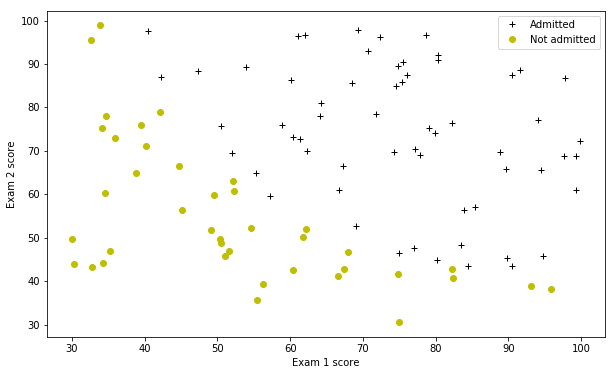

In [4]:
def plotData():
    plt.figure(figsize = (10, 6))
    plt.plot(positive[:,1], positive[:,2], 'k+', label = 'Admitted')
    plt.plot(negative[:,1], negative[:,2], 'yo', label = 'Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    
plotData()

### Implement logistic regression

(0, 1)

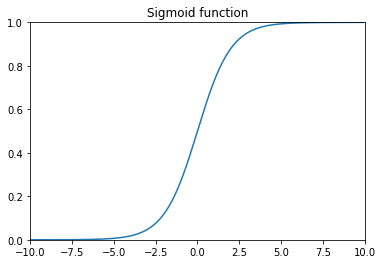

In [5]:
#Import vectorized sigmoid function
from scipy.special import expit

x = np.arange(-10, 10, .1)
plt.plot(x, expit(x))
plt.title('Sigmoid function')
plt.xlim([-10, 10])
plt.ylim([0, 1])

In [6]:
def h(theta, X):
    return expit(np.dot(X, theta))

def costFunction(theta, X, y, someLambda = 0.):
    firstTerm = np.dot(-np.array(y).T, np.log(h(theta, X)))
    secondTerm = np.dot((1 - np.array(y)).T, np.log(1 - h(theta, X)))
    regulTerm = (someLambda / 2) * np.sum(np.dot(theta[1:].T, theta[1:]))
    return float( (1. / m) * ( np.sum(firstTerm - secondTerm) + regulTerm ) )

#If everything is correct, the cost function return 0.693 for thetas equal to 0
thetaInit = np.zeros((X.shape[1], 1))
costFunction(thetaInit, X, y)

0.6931471805599452

In [7]:
from scipy import optimize

In [8]:
def optimizeTheta(theta, X, y, someLambda = 0.):
    result = optimize.fmin(costFunction, x0 = theta, args = (X, y, someLambda), maxiter = 400, full_output = True)
    return result[0], result[1]

In [9]:
theta, mincost = optimizeTheta(thetaInit, X, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


#### Compute cost with the optimal thetas

In [10]:
print(costFunction(theta, X, y))

0.2034977015902151


#### Visualize the decision boundary

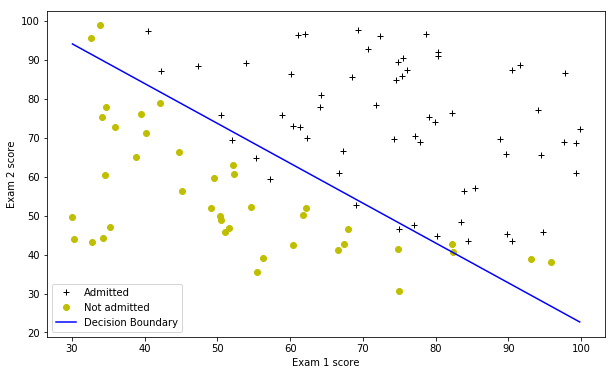

In [11]:
boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1. / theta[2]) * (theta[0] + theta[1] * boundary_xs)
plotData()
plt.plot(boundary_xs, boundary_ys,'b-', label = 'Decision Boundary')
plt.legend()

In [12]:
# A student who scored 45 and 85 respectively
# on Exam 1 and 2 should have an admission
#probability of 0.776 (77.6%)

print(h(theta, np.array([1, 45, 85])))

0.7762915904112411


#### Assess the quality of the classifier

In [13]:
def qualClassifier(theta, x):
    return h(theta,x) >= 0.5

#Compute the percentage of samples I got correct:
posRight = float(np.sum(qualClassifier(theta, positive)))
negRight = float(np.sum(np.invert(qualClassifier(theta, negative))))
total = len(positive) + len(negative)
percentage = float(posRight + negRight)/total
print ("Fraction of correctly predicted samples: %f." % percentage)

Fraction of correctly predicted samples: 0.890000.


## Regularized Logistic Regression

### Import and visualize data

In [14]:
data = 'data/ex2data2.txt'

cols = np.loadtxt(data, delimiter = ',', usecols = (0, 1, 2), unpack = True)

X = np.transpose(np.array(cols[:-1]))
X = np.insert(X, 0, 1, axis = 1)

y = np.transpose(np.array(cols[-1:]))

m = y.size

print(X[:5])
print(y[:5])
print(m)

[[ 1.        0.051267  0.69956 ]
 [ 1.       -0.092742  0.68494 ]
 [ 1.       -0.21371   0.69225 ]
 [ 1.       -0.375     0.50219 ]
 [ 1.       -0.51325   0.46564 ]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
118


In [15]:
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

# Make sure we have all data
print((len(pos) + len(neg)) == X.shape[0])

True


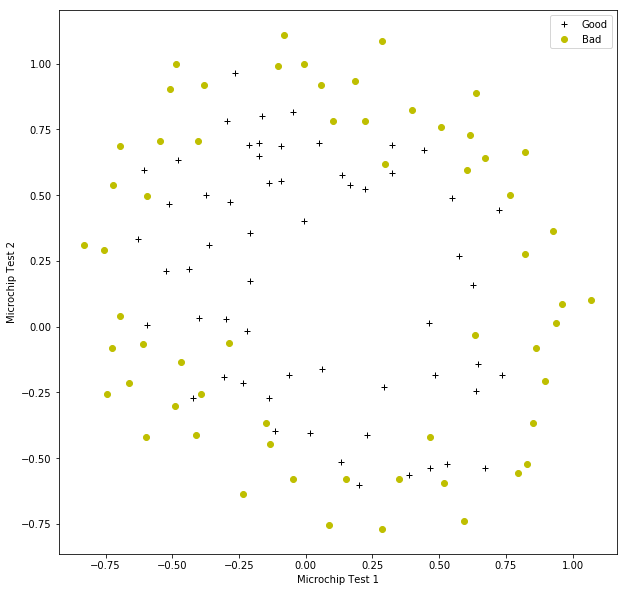

In [16]:
def plotData():
    plt.plot(pos[:,1], pos[:,2], 'k+', label = 'Good')
    plt.plot(neg[:,1], neg[:, 2], 'yo', label = 'Bad')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()

plt.figure(figsize = (10, 10))
plotData()

#### Feature mapping

In [17]:
def mapFeature( x1col, x2col ):
    
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

mappedX = mapFeature(X[:,1], X[:,2])

#### Cost function and gradient

In [18]:
#Initializing with 0s should give 0.693
theta_initial = np.zeros((mappedX.shape[1], 1))
costFunction(theta_initial, mappedX, y)

0.6931471805599453

#### Find optimal learning parameters

In [19]:
def opRegParams(theta, X, y, someLambda = 0.):
    result = optimize.minimize(costFunction, theta, args=(X, y, someLambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun

theta, costMin = opRegParams(theta_initial, mappedX, y)

#### Plot the decision boundary

In [20]:
def plotBoundary(theta, X, y, someLambda = 0.):
    
    theta, costMin = opRegParams(theta, X, y, someLambda)
    x_s = np.linspace(-1, 1.5, 50)
    y_s = np.linspace(-1, 1.5, 50)
    z_s = np.zeros((len(x_s), len(y_s)))
    
    for i in range(len(x_s)):
        for j in range(len(y_s)):
            feat_ij = mapFeature(np.array([x_s[i]]), np.array([y_s[j]]))
            z_s[i][j] = np.dot(theta, feat_ij.T)
    z_s = z_s.transpose()
    
    u, v = np.meshgrid(x_s, y_s)
    contour = plt.contour(x_s, y_s, z_s, [0])
    db_label = {0: 'Lambda = %d' %someLambda}
    plt.clabel(contour, inline = 1, fontsize = 13, fmt = db_label)
    plt.title('Decision Boundary')

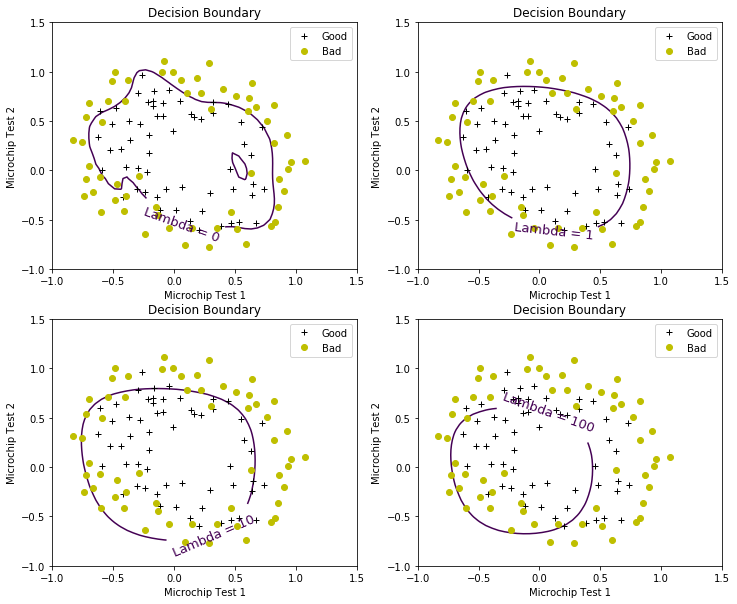

In [21]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)

As observed above, when lambda (the regularization parameter) increases, the model underfits the training dataset. On the other hand, a lambda of 0 overfits the model.

## Practical Logistic Regression Implementation

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data = 'data/ex2data1.txt'

cols = np.loadtxt(data, delimiter = ',', usecols = (0, 1, 2), unpack = True)

X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

logReg = LogisticRegression()
logReg.fit(x_train, y_train.ravel()) # Using ravel() because the model expects a 2D matrix
predictions = logReg.predict(x_test)
score = logReg.score(x_test, y_test)
print(score)

0.95


The first model resulted in an accuracy of 89%. Here, using *scikit*'s logistic regression algorithm, an accuracy of 95% was achieved for its predictions.

In [49]:
data = 'data/ex2data2.txt'

cols = np.loadtxt(data, delimiter = ',', usecols = (0, 1, 2), unpack = True)

X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

logReg = LogisticRegression(C = 1e6)
logReg.fit(x_train, y_train.ravel()) # Using ravel() because the model expects a 2D matrix
predictions = logReg.predict(x_test)
score = logReg.score(x_test, y_test)
print(score)

0.5


This score above is very bad. Basically the model is as good as guessing at random. Must find a way to improve this.